# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle

In [2]:
#Start Calculating the Running Time
Start = time.time()

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'goldenbear'

## Create and Run `ForestModel` instance

In [4]:
fm = ws3.forest.ForestModel(model_name='goldenbear',
                            model_path='./data/woodstock_model_files_goldenbear',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

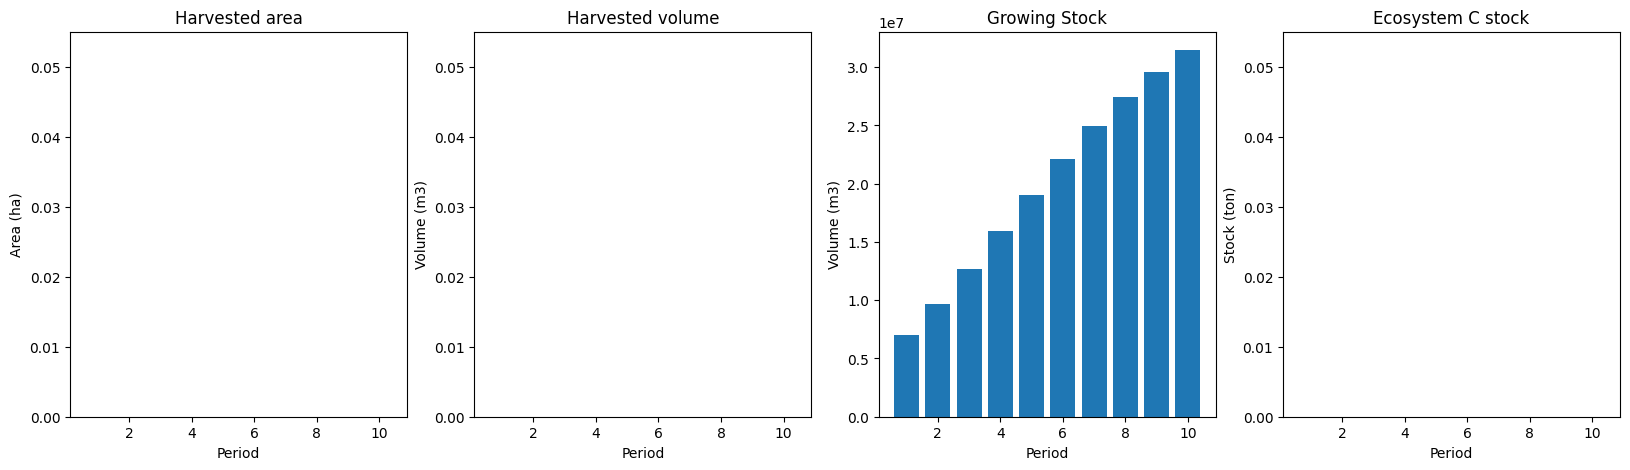

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [8]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [9]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
# all_pools = biomass_pools + dom_pools + emissions_pools
all_pools = biomass_pools + dom_pools

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [11]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [12]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,7.144077e+06,1.998170e+07,2.712578e+07,0.000000,0.000000,0.000000
1,7.276708e+06,1.998549e+07,2.726219e+07,435162.492686,571575.647093,-136413.154407
2,7.409069e+06,1.999109e+07,2.740015e+07,438131.530633,576091.686330,-137960.155697
3,7.540872e+06,1.999840e+07,2.753928e+07,441090.837166,580213.676778,-139122.839612
4,7.672226e+06,2.000734e+07,2.767957e+07,444034.437628,584327.359615,-140292.921987
...,...,...,...,...,...,...
96,1.649951e+07,2.372710e+07,4.022661e+07,608901.203780,706817.788031,-97916.584251
97,1.654539e+07,2.377783e+07,4.032322e+07,609874.538109,706489.331653,-96614.793544
98,1.659022e+07,2.382849e+07,4.041871e+07,610834.121239,706318.529561,-95484.408321


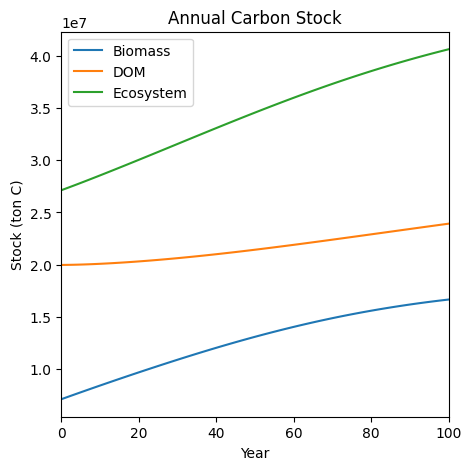

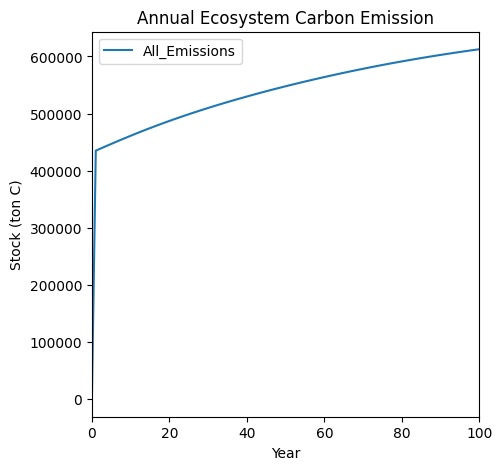

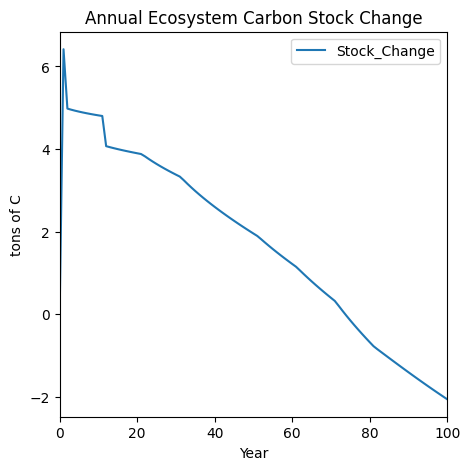

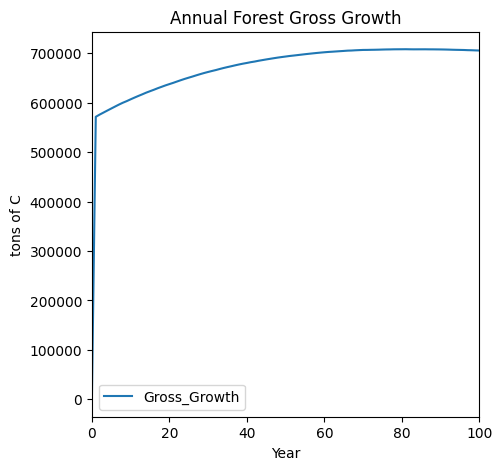

In [13]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [14]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [15]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,100,12,12,softwood,FALSE,20,3.238770,0,0,fire,fire
1,tsa04,0,1,100,12,12,softwood,FALSE,21,2.524772,0,0,fire,fire
2,tsa04,0,1,100,12,12,softwood,FALSE,26,3.917482,0,0,fire,fire
3,tsa04,0,1,100,30,30,softwood,FALSE,23,10.346732,0,0,fire,fire
4,tsa04,0,1,100,30,30,softwood,FALSE,24,8.210417,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3900,tsa04,1,33,1201,42,42,hardwood,FALSE,88,33.639536,0,0,fire,fire
3901,tsa04,1,33,1201,42,42,hardwood,FALSE,94,32.511218,0,0,fire,fire
3902,tsa04,1,33,1201,42,42,hardwood,FALSE,109,133.464928,0,0,fire,fire
3903,tsa04,1,33,1201,42,42,hardwood,FALSE,116,14.516802,0,0,fire,fire


In [16]:
# Set Age and Area to 1 and 1.0
df = sit_tables['sit_inventory']
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)
df

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,100,12,12,softwood,FALSE,1,1.0,0,0,fire,fire
1,tsa04,0,1,100,30,30,softwood,FALSE,1,1.0,0,0,fire,fire
2,tsa04,0,2,100,10,10,softwood,FALSE,1,1.0,0,0,fire,fire
3,tsa04,0,2,100,12,12,softwood,FALSE,1,1.0,0,0,fire,fire
4,tsa04,0,2,100,28,28,softwood,FALSE,1,1.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,tsa04,1,33,1201,32,32,hardwood,FALSE,1,1.0,0,0,fire,fire
254,tsa04,1,33,1201,33,33,hardwood,FALSE,1,1.0,0,0,fire,fire
255,tsa04,1,33,1201,40,40,hardwood,FALSE,1,1.0,0,0,fire,fire
256,tsa04,1,33,1201,41,41,hardwood,FALSE,1,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [17]:
# # Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [18]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

In [19]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
# fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
#                                               left_on=["identifier", "timestep"], 
#                                               right_on=["identifier", "timestep"])

In [20]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
# fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [21]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
# c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [22]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [23]:
# Generate carbon yield curves for net emission
# c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
# c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [24]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key           timestep                                                  
tsa04 0 1 100 12 12 0              0.000002         0.008520       0.000000   
                    1              0.000033         0.037900       0.000000   
                    2              0.000155         0.090669       0.000000   
                    3              0.000468         0.168216       0.000000   
                    4              0.001099         0.267941       0.003515   
...                                     ...              ...            ...   
tsa04 1 7 100 8 8   96            11.589202         4.069369      18.650444   
                    97            12.066260         4.103002      18.737941   
                    98            12.540684         4.136631      18.824823   
                    99            13.012605         4.170227      18.911115   
                    100           13.506792         4.205532      19.001338   

                              SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key           timestep                                           
tsa04 0 1 100 12 12 0                    0.001086           0.000806   
                    1                    0.004837           0.003584   
                    2                    0.011591           0.008572   
                    3                    0.021555           0.015893   
                    4                    0.034887           0.025621   
...                                           ...                ...   
tsa04 1 7 100 8 8   96                   5.990698           1.625903   
                    97                   6.112540           1.636859   
                    98                   6.234032           1.647442   
                    99                   6.355187           1.657669   
                    100                  6.482365           1.668068   

                              HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key           timestep                                                  
tsa04 0 1 100 12 12 0                   0.0              0.0            0.0   
                    1                   0.0              0.0            0.0   
                    2                   0.0              0.0            0.0   
                    3                   0.0              0.0            0.0   
                    4                   0.0              0.0            0.0   
...                                     ...              ...            ...   
tsa04 1 7 100 8 8   96                  0.0              0.0            0.0   
                    97                  0.0              0.0            0.0   
                    98                  0.0              0.0            0.0   
                    99                  0.0              0.0            0.0   
                    100                 0.0              0.0            0.0   

                              HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key           timestep                                          ...   
tsa04 0 1 100 12 12 0                         0.0                0.0  ...   
                    1                         0.0                0.0  ...   
                    2                         0.0                0.0  ...   
                    3                         0.0                0.0  ...   
                    4                         0.0                0.0  ...   
...                                           ...                ...  ...   
tsa04 1 7 100 8 8   96                        0.0                0.0  ...   
                    97                        0.0                0.0  ...   
                    98                        0.0                0.0  ...   
                    99                        0.0                0.0  ...   
                    100                       0.0                0.0  ...   

                              Mediu

Curvs Calibration

In [25]:
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [26]:
with open(f'{case_study}_c_curves_p.pkl', 'wb') as file:
    pickle.dump(c_curves_p, file)

In [27]:
with open(f'{case_study}_c_curves_p.pkl', 'rb') as file:
    c_curves_p = pickle.load(file)

In [28]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])
plugin_c_curves(fm, c_curves_p, pools=sum_pools)

found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '30', '30')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '28', '28')
found match for mask ('?', '?', '?', '?', '30', '30')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '28', '28')
found match for mask ('?', '?', '?', '?', '29', '29')
found match for mask ('?', '?', '?', '?', '30', '30')
found match for mask ('?', '?', '?', '?', '37', '37')
found match for mask ('?', '?', '?', '?', '38', '38')
found match for mask ('?', '?', '?', '?', '39', '39')
found match for mask ('?', '?', '?', '?', '25', '25')
found match for mask ('?', '?', '?', '?', '27', '27')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?'

In [29]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f185b5f59c0>),
   ('ecosystem', <ws3.core.Curve at 0x7f184d15c6d0>),
   ('biomass', <ws3.core.Curve at 0x7f184d15f370>),
   ('DOM', <ws3.core.Curve at 0x7f184d15fa90>),
   ('ecosystem', <ws3.core.Curve at 0x7f184d15c6d0>),
   ('biomass', <ws3.core.Curve at 0x7f184d15f370>),
   ('DOM', <ws3.core.Curve at 0x7f184d15fa90>),
   ('ecosystem', <ws3.core.Curve at 0x7f184d15c6d0>),
   ('biomass', <ws3.core.Curve at 0x7f184d15f370>),
   ('DOM', <ws3.core.Curve at 0x7f184d15fa90>),
   ('ecosystem', <ws3.core.Curve at 0x7f184d15c6d0>),
   ('biomass', <ws3.core.Curve at 0x7f184d15f370>),
   ('DOM', <ws3.core.Curve at 0x7f184d15fa90>),
   ('ecosystem', <ws3.core.Curve at 0x7f184d15c6d0>),
   ('biomass', <ws3.core.Curve at 0x7f184d15f370>),
   ('DOM', <ws3.core.Curve at 0x7f184d15fa90>),
   ('ecosystem', <ws3.core.Curve at 0x7f184d15c6d0>),
   ('biomass', <ws3.core.Curve at 0x7f184d

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

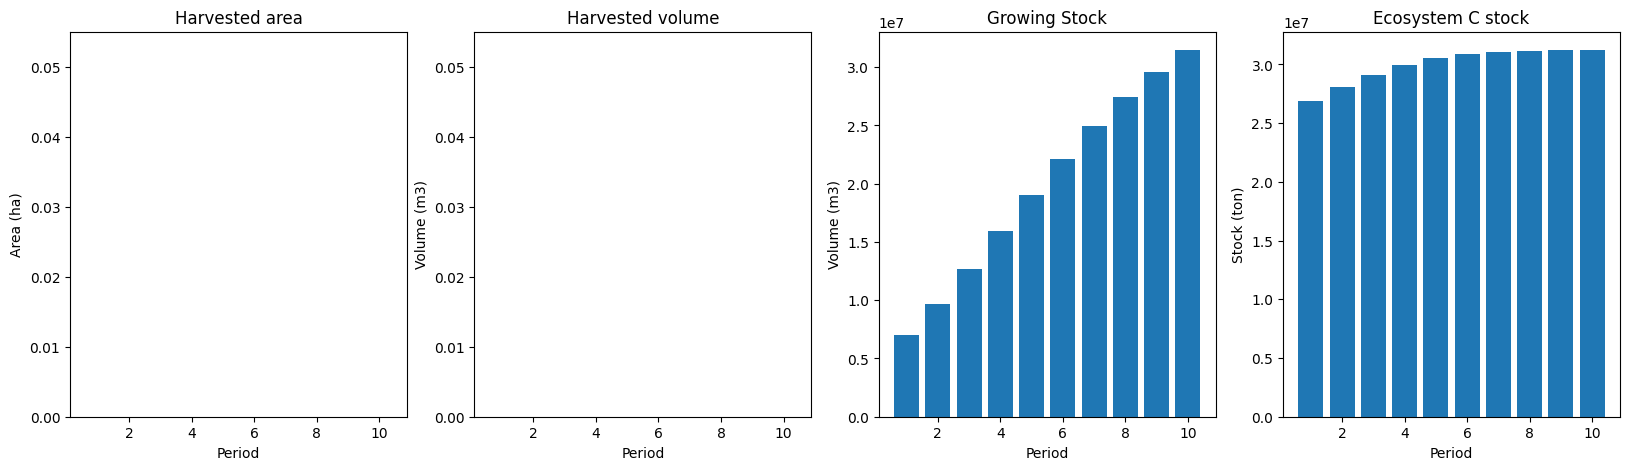

In [30]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

In [31]:
# softwood_volume_yname='swdvol' 
# hardwood_volume_yname='hwdvol'
# n_yield_vals=100

In [32]:
# sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [33]:
# Replace the Sit_events file in the sit tables
# sit_tables['sit_events'] = sit_events

In [34]:
# sit_events

In [35]:

# sit_tables['sit_inventory']

In [36]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,30.392316,42618.070413,42648.462729,0.000000,0.000000,0.000000
1,62.431270,41754.026435,41816.457706,877.170227,45.165204,832.005023
2,97.735588,40950.723512,41048.459099,823.350680,55.352074,767.998606
3,136.358435,40199.273831,40335.632267,778.274066,65.447233,712.826833
4,178.331738,39493.298524,39671.630262,739.756125,75.754120,664.002005
...,...,...,...,...,...,...
96,15108.639902,28700.066589,43808.706492,703.071864,931.265856,-228.193992
97,15290.899494,28746.373774,44037.273269,705.918029,934.484806,-228.566777
98,15472.550274,28793.677134,44266.227408,708.730721,937.684861,-228.954139


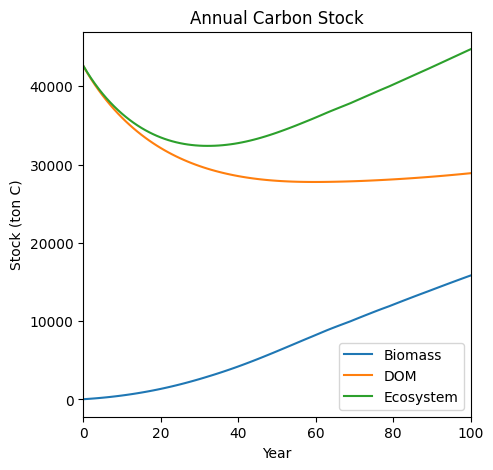

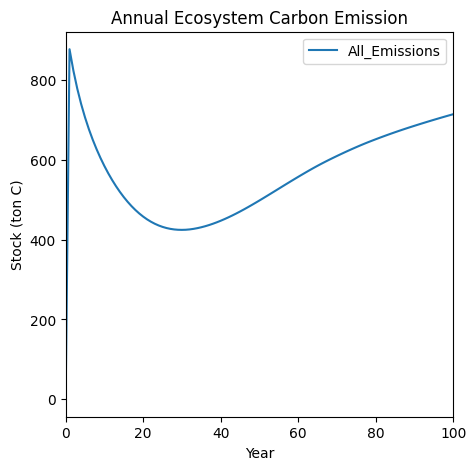

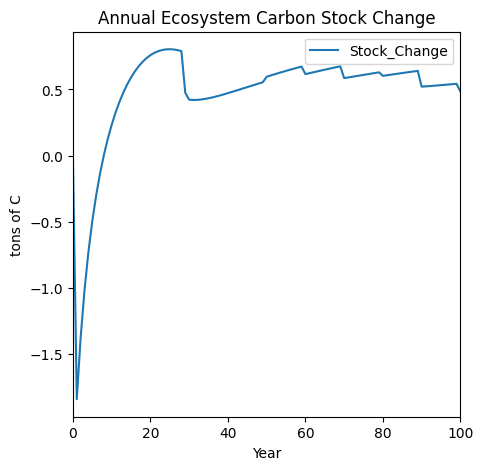

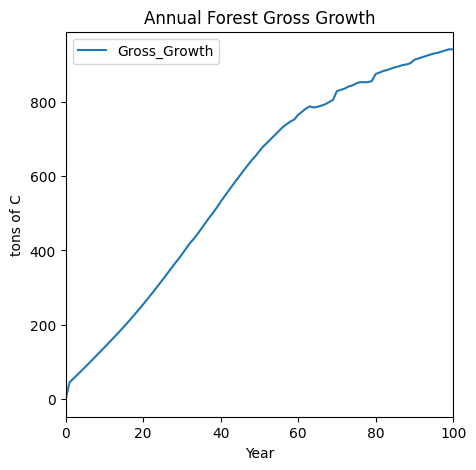

In [37]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

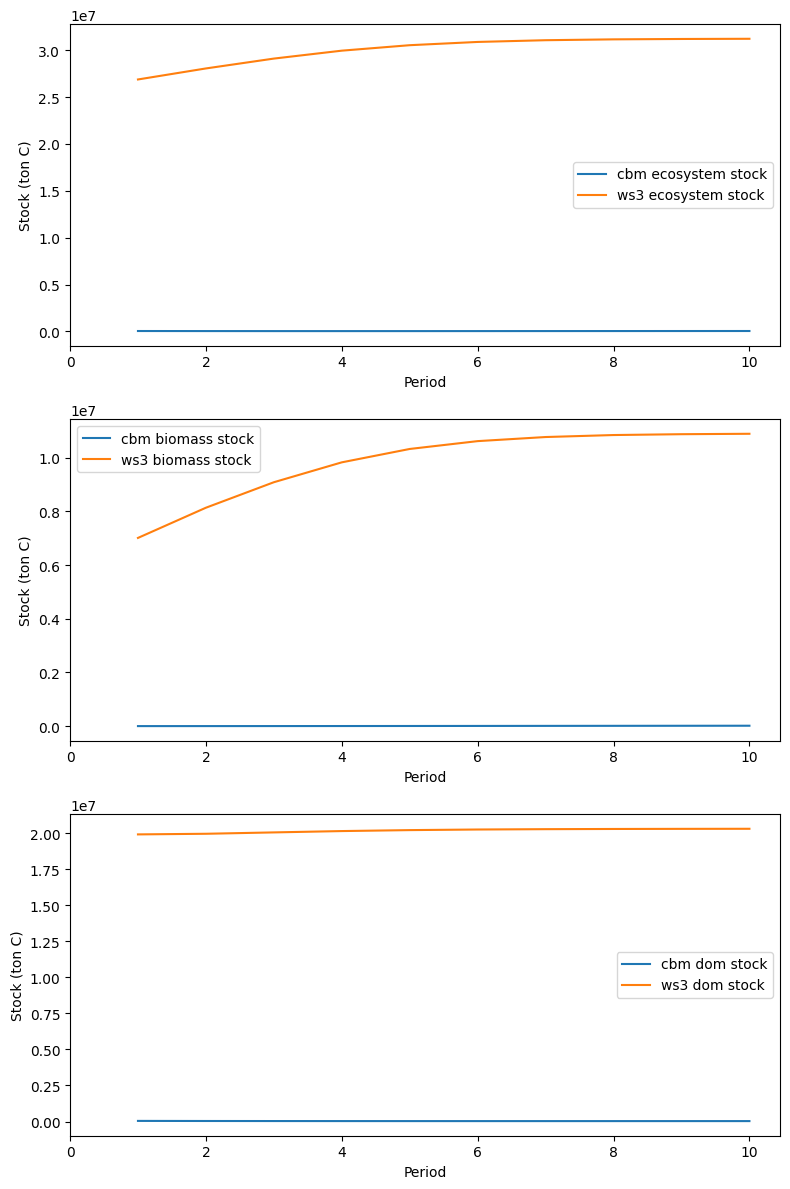

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1      62.431270  41754.026435  41816.457706          0.000000
 1       2     570.192675  35513.015530  36083.208205      -5733.249501
 2       3    1455.539161  31822.351590  33277.890751      -2805.317454
 3       4    2746.639650  29640.920477  32387.560127       -890.330624
 4       5    4391.648471  28435.389118  32827.037588        439.477461
 5       6    6361.184805  27887.937333  34249.122138       1422.084549
 6       7    8437.835687  27772.919844  36210.755531       1961.633393
 7       8   10387.603906  27885.559153  38273.163059       2062.407528
 8       9   12299.923500  28131.155079  40431.078579       2157.915519
 9      10   14182.461925  28483.887191  42666.349116       2235.270538,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   7.011624e+06  1.992145e+07  2.688034e+07      0.000000e+00
 1       2   8.136828e+06  1.996478e+07  2.805671e+07      1.17

In [38]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
from util_opt import compare_ws3_cbm
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="individual")

In [39]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 6.6 minutes to run this script.
